In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils.data as loader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [0]:
in_vect_size = 200

In [4]:
class generator(nn.Module):
    """
    Generator for 3D-GAN-
    The generator consists of five fully convolution layers with numbers of channels
    {512, 256, 128, 64, 1}, kernel sizes {4, 4, 4, 4, 4}, and strides {1, 2, 2, 2, 2}. 
    We add ReLU and batch normalization layers between convolutional layers, and a Sigmoid
    layer at the end. The input is a 200-dimensional vector, and the output is a 64 × 64 × 64 
    matrix with values in [0, 1].
    """
    def __init__(self):
        super().__init__()
        self.layer1=nn.Sequential(
            nn.ConvTranspose3d(in_channels=200,out_channels=512,kernel_size=3,stride=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
        )
        self.layer2=nn.Sequential(
            nn.ConvTranspose3d(in_channels=512,out_channels=256,kernel_size=3,stride=2),
            nn.BatchNorm3d(256),
            nn.ReLU(),
        )
        self.layer3=nn.Sequential(
            nn.ConvTranspose3d(in_channels=256,out_channels=128,kernel_size=3,stride=2),
            nn.BatchNorm3d(128),
            nn.ReLU(),
        )
        self.layer4=nn.Sequential(
            nn.ConvTranspose3d(in_channels=128,out_channels=64,kernel_size=3,stride=2),
            nn.BatchNorm3d(64),
            nn.ReLU(),
        )
        self.layer5=nn.Sequential(
            nn.ConvTranspose3d(in_channels=64,out_channels=1,kernel_size=4,stride=2),
            nn.Sigmoid(),
        )
    
    def forward(self,x):
        bsize=x.size(0)
        x=x.view(bsize,in_vect_size,1,1,1)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        return x
G_=generator().to(device)
summary(G_,(1,in_vect_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose3d-1         [-1, 512, 3, 3, 3]       2,765,312
       BatchNorm3d-2         [-1, 512, 3, 3, 3]           1,024
              ReLU-3         [-1, 512, 3, 3, 3]               0
   ConvTranspose3d-4         [-1, 256, 7, 7, 7]       3,539,200
       BatchNorm3d-5         [-1, 256, 7, 7, 7]             512
              ReLU-6         [-1, 256, 7, 7, 7]               0
   ConvTranspose3d-7      [-1, 128, 15, 15, 15]         884,864
       BatchNorm3d-8      [-1, 128, 15, 15, 15]             256
              ReLU-9      [-1, 128, 15, 15, 15]               0
  ConvTranspose3d-10       [-1, 64, 31, 31, 31]         221,248
      BatchNorm3d-11       [-1, 64, 31, 31, 31]             128
             ReLU-12       [-1, 64, 31, 31, 31]               0
  ConvTranspose3d-13        [-1, 1, 64, 64, 64]           4,097
          Sigmoid-14        [-1, 1, 64,

In [5]:
class discriminator(nn.Module):
    """
    Discriminator for 3D-GAN-
    As a mirrored version of the generator, the discriminator takes as input a 
    64 × 64 × 64 matrix, and outputs a real number in [0, 1]. The discriminator 
    consists of 5 volumetric convolution layers, with numbers of channels {64,128,256,512,1}, 
    kernel sizes {4,4,4,4,4}, and strides {2, 2, 2, 2, 1}. There are leaky ReLU layers of 
    parameter 0.2 and batch normalization layers in between, and a Sigmoid layer at the end.
    """
    def __init__(self):
        super().__init__()
        self.layer1=nn.Sequential(
            nn.Conv3d(in_channels=1,out_channels=64,kernel_size=4,stride=2),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2)
        )
        self.layer2=nn.Sequential(
            nn.Conv3d(in_channels=64,out_channels=128,kernel_size=4,stride=2),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2)
        )
        self.layer3=nn.Sequential(
            nn.Conv3d(in_channels=128,out_channels=256,kernel_size=4,stride=2),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2)
        )
        self.layer4=nn.Sequential(
            nn.Conv3d(in_channels=256,out_channels=512,kernel_size=4,stride=2),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2)
        )
        self.layer5=nn.Sequential(
            nn.Conv3d(in_channels=512,out_channels=1,kernel_size=2,stride=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        bsize=x.size(0)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        x=x.view(bsize,1)
        return x
D_=discriminator().to(device)
summary(D_,(1,64,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 31, 31, 31]           4,160
       BatchNorm3d-2       [-1, 64, 31, 31, 31]             128
         LeakyReLU-3       [-1, 64, 31, 31, 31]               0
            Conv3d-4      [-1, 128, 14, 14, 14]         524,416
       BatchNorm3d-5      [-1, 128, 14, 14, 14]             256
         LeakyReLU-6      [-1, 128, 14, 14, 14]               0
            Conv3d-7         [-1, 256, 6, 6, 6]       2,097,408
       BatchNorm3d-8         [-1, 256, 6, 6, 6]             512
         LeakyReLU-9         [-1, 256, 6, 6, 6]               0
           Conv3d-10         [-1, 512, 2, 2, 2]       8,389,120
      BatchNorm3d-11         [-1, 512, 2, 2, 2]           1,024
        LeakyReLU-12         [-1, 512, 2, 2, 2]               0
           Conv3d-13           [-1, 1, 1, 1, 1]           4,097
          Sigmoid-14           [-1, 1, 

In [0]:
from torch.utils.data import Dataset
import gzip
import os
class ModelNet10GAN(Dataset):
    """
    Custom dataset for training a 3D-GAN, without using a variational autoencoder.
    I have not implemented download of dataset.
    """
    def __init__(self, dir="./", download=False):
        """
        Args:
            dir (string): Path in which you want the dataset 
                to be saved (keep a minimum space of 9 GBs).
            download (boolean): Set to True if you want to download. 
                Default=False.
        """
        self.dir=dir
        self.download=download
        if not self._check_exists():
            raise RuntimeError('modelnet10.npy.gz not present in '+self.dir)
        with gzip.open(self.dir+'modelnet10.npy.gz','rb') as f:
            self.arr=np.load(f)
        
        

    def __getitem__(self, ind):
        """
        Args:
            ind (int): Index of the sample you want. 

        Returns:
            Tensor: (torch.Tensor, Size: (1,64,64,64))
        """
        return torch.tensor(self.arr[ind+1])

    def __len__(self):
        return (self.arr.shape[0]-1)

    def _check_exists(self):
        return (os.path.exists(self.dir+"modelnet10.npy.gz"))

In [7]:
dataset=ModelNet10GAN(dir='./')
batchsize=128
data_loader=loader.DataLoader(dataset, batch_size=batchsize)
print(len(data_loader))

32


In [0]:
num_epochs=10
d_optimizer=optim.Adam(D_.parameters(),lr=0.00001,betas=(0.5,0.999))
g_optimizer=optim.Adam(G_.parameters(),lr=0.0025,betas=(0.5,0.999))
g_losses=[]
d_losses=[]
models=[]
criterion=nn.BCELoss()

In [0]:
def train_discriminator(optimizer,real_data,fake_data,prev_acc,device):

  optimizer.zero_grad()
  prediction_real = D_(real_data)
  loss_real = criterion(prediction_real,torch.ones((real_data.size(0),1)).to(device))
  loss_real.backward()
  p_acc=torch.mean(prediction_real)

  prediction_fake = D_(fake_data)
  p_acc+=torch.mean(prediction_fake)
  loss_fake = criterion(prediction_fake,torch.zeros((fake_data.size(0),1)).to(device))
  loss_fake.backward()

  if prev_acc<=0.8 :
      optimizer.step()

  return (loss_real+loss_fake),p_acc/2
def train_generator(optimizer,fake_data,device):

  optimizer.zero_grad()
  prediction = D_(fake_data)
  error = criterion(prediction,torch.ones((fake_data.size(0),1)).to(device))
  error.backward()
  optimizer.step()

  return error
def noise(size,inp_vec_size,device):
    return torch.rand((size,inp_vec_size),device=device)

In [10]:
import time
G_.train()
D_.train()
prev_acc=0.5
for epoch in range(num_epochs):
    start=time.time()
    running_g_error=0.0
    running_d_error=0.0
    for data in tqdm(data_loader):
        mods=data.to(device).float()
        fake_data=G_(noise(batchsize,in_vect_size,device)).detach()
        real_data=mods
        d_error,prev_acc=train_discriminator(d_optimizer,real_data,fake_data,prev_acc,device)
        print(prev_acc)
        running_d_error+=d_error
        fake_data_1=G_(noise(batchsize,in_vect_size,device))
        running_g_error+=train_generator(g_optimizer,fake_data_1,device)
        del mods
        del real_data
        del fake_data
        del fake_data_1
    g_losses.append(running_g_error/32)
    d_losses.append(running_d_error/32)
    if epoch in [0,1,2,3,4,5,6,7,8,9]:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.voxels(G_(noise(1,in_vect_size,device)).squeeze().detach().cpu().numpy(),facecolors='red')
        fig.savefig('fig{0}.png'.format(epoch+1))
        plt.close()
    print("Epoch: ",epoch+1," G_loss=",running_g_error.item(),' D_loss=',running_d_error.item(),' time elapsed=',(time.time()-start)/60.0)
    torch.cuda.empty_cache()

tensor(0.4383, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7276, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7578, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7562, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7659, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7556, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7611, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7740, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7726, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7720, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7692, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7843, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7677, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7812, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7801, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7813, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7847, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7925, device='cuda:0', grad_fn=<DivBack

tensor(0.8144, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8114, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8174, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8066, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8172, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8057, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7988, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8191, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8201, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8130, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8120, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8269, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8024, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8182, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8129, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8141, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8166, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8247, device='cuda:0', grad_fn=<DivBack

tensor(0.8201, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8144, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8200, device='cuda:0', grad_fn=<DivBackward0>)


KeyboardInterrupt: ignored

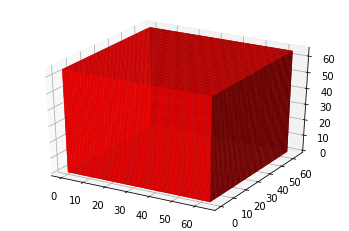

In [11]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(G_(noise(1,in_vect_size,device)).squeeze().detach().cpu().numpy(),facecolors='red')
fig.savefig('fig{0}.png'.format(epoch+1))
plt.show()